In [7]:
import numpy as np
from sklearn.datasets import fetch_openml
import cv2
from sklearn.cluster import KMeans
import skimage.io
from matplotlib import pyplot as plt
import tempfile
import tarfile
import io
from pathlib import Path
import pickle
from skimage.color import rgb2gray
import requests
import math

In [107]:
N_CLUSTERS=128
QUERY_IMAGE_INDEX=777

In [9]:
def fetch_mnist():
    mnist = fetch_openml('mnist_784', version=1,)
    return mnist['data'].reshape(-1, 28, 28).astype(np.uint8)

In [10]:
def fetch_cifar10_batch1():
    response = requests.get('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
    tar = tarfile.open(fileobj=io.BytesIO(response.content))
    with tempfile.TemporaryDirectory() as tempdir:
        tar.extractall(tempdir)
        path = Path(tempdir) / "cifar-10-batches-py" / "data_batch_1"
        dataset = pickle.loads(path.read_bytes(),encoding='bytes')
        return (255 * rgb2gray(dataset[b'data'].reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1]))).astype(np.uint8)

In [11]:
def fetch_caltech101():
    response = requests.get('http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz')
    tar = tarfile.open(fileobj=io.BytesIO(response.content))
    with tempfile.TemporaryDirectory() as tempdir:
        tar.extractall(tempdir)
        paths = list(Path(tempdir).glob("*/*/*.jpg"))
        return [cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2GRAY) for p in paths]

In [85]:
# Fetch dataset
data = fetch_mnist()
#data = fetch_cifar10_batch1()
#data = fetch_caltech101()

In [86]:
# Shrink dataset
if True:
    data = data[:1024]

In [87]:
# Calculate SIFT features
sift = cv2.xfeatures2d_SIFT.create()
keypoints, features = zip(*[sift.detectAndCompute(d, None) for d in data])

In [88]:
# Define a function to calculate BoF
all_features = np.vstack([f for f in features if f is not None])
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(all_features)
def calc_bof(feature):
    if feature is None:
        return np.zeros(kmeans.n_clusters).astype(np.int32)
    codes = kmeans.predict(feature)
    bof, _ = np.histogram(codes, bins=range(kmeans.n_clusters + 1))
    return bof

In [89]:
# Clculate BoF
bof_features = np.array([calc_bof(f) for f in features])

In [99]:
def calc_score(bof_features, query_index):
    # L2 norm is 1.0
    normalized = bof_features / (np.sqrt(np.diag(bof_features @ bof_features.T)).reshape(-1, 1) + 1e-12)
    return np.sum(np.power(bof_features - bof_features[query_index], 2),axis=1)

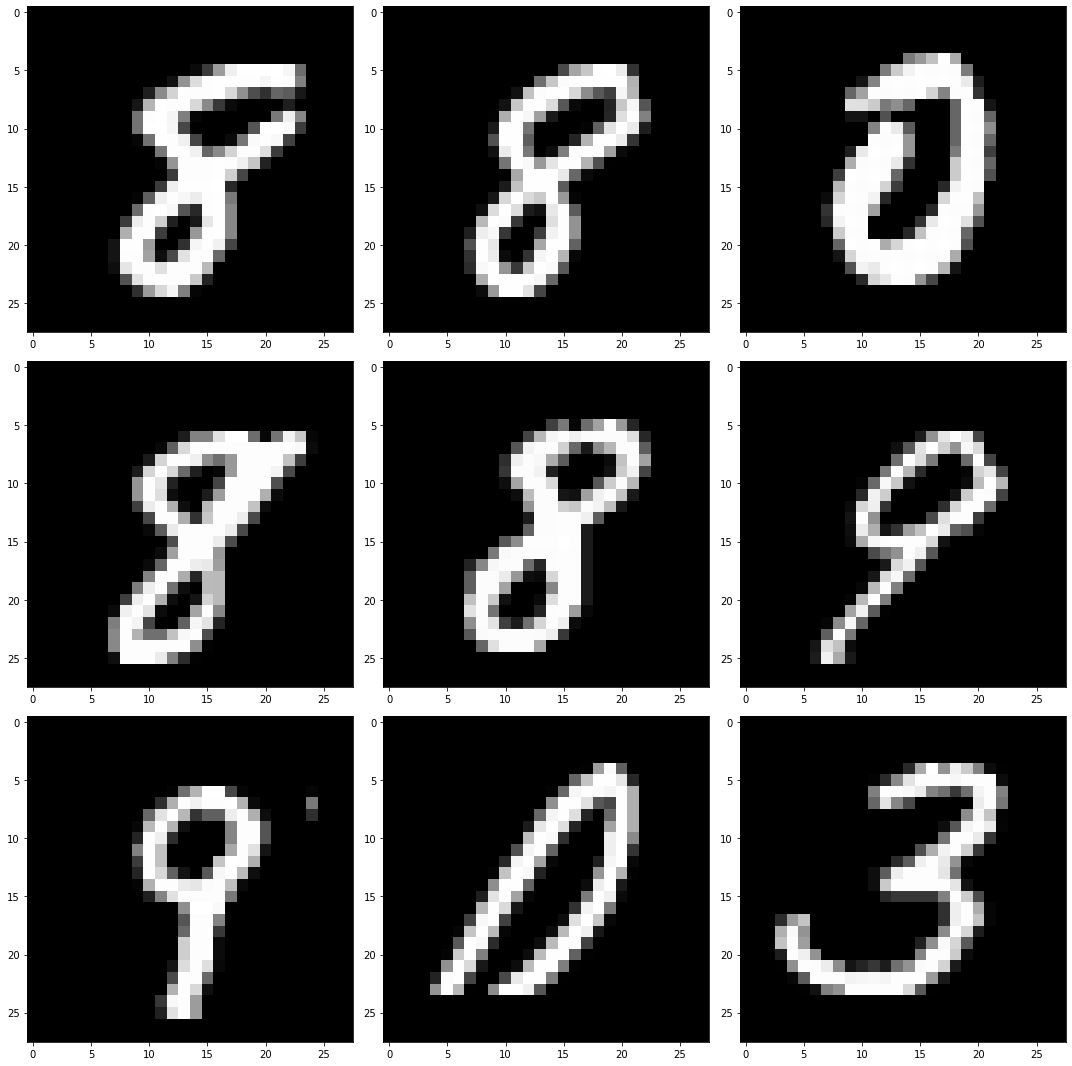

In [108]:
# Get top 12th similar images
smilar_image_indice = np.argsort(calc_score(bof_features, QUERY_IMAGE_INDEX))[:9]
plt.subplots(3,3,figsize=(15,15))
for i,j in enumerate(smilar_image_indice):
    plt.subplot(3,3,i + 1)
    skimage.io.imshow(data[j])
plt.show()